In [1]:
# %load paste_video_classification.py
# 这个代码每个epoch都跑一遍训练集和验证集

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# 参数
learning_rate = 0.001
momentum = 0.9
epochs = 20
batch_size = 4
display_step = 1
shuffle = True

In [2]:
# 加载vgg16预训练模型
model = models.vgg16(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(True),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4))

In [3]:
# 数据准备
# crop:裁剪 resize:缩放 flip:翻转
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# your image data file
data_dir = './images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
# torchvision.datasets.ImageFolder返回的是list，这里用torch.utils.data.DataLoader类将list类型的输入数据封装成Tensor数据格式
dataloders = {x: torch.utils.data.DataLoader(image_datasets,
                                             batch_size,
                                             shuffle) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [4]:
# 是否使用GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

print("use_gpu: " + str(use_gpu))
    
# 定义损失函数，这里采用交叉熵函数
loss_fn = nn.CrossEntropyLoss()

# 定义优化函数，这里采用随机梯度下降法
optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

# 定义学习率的变化策略，这里采用torch.optim.lr_scheduler模块的StepLR类，表示每隔step_size个epoch就将学习率降为原来的gamma倍
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

use_gpu: True


In [6]:
# 开始训练
since = time.time()
best_model_wts = model.state_dict()
best_acc = 0.0
loss_train = []
acc_train = []
loss_val = []
acc_val = []

for epoch in range(epochs):
    if epoch % display_step == 0:
        print('Epoch [{}/{}]:'.format(epoch + 1, epochs))

    # 每一轮都跑一遍训练集和验证集
    for phase in ['train', 'val']:
        if phase == 'train':
            i = 1
            j = 1
            # exp_lr_scheduler.step()
            model.train()  # 把module设成training模式，对Dropout和BatchNorm有影响
        else:
            i = 1
            j = 2
            model.eval()  # 把module设置为评估模式

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for data in dataloders[phase]:
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            # if use_gpu:
            #     inputs = inputs.cuda()
            #     labels = labels.cuda()
            # else:
            #     inputs, labels = Variable(inputs), Variable(labels)

            # PyTorch更新至0.4.0后，将Variable和Tensor合并
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # 先将网络中的所有梯度置0
            optimizer.zero_grad()

            # 网络的前向传播
            outputs = model(inputs)

            # 计算损失
            loss = loss_fn(outputs, labels)

            # 得到模型预测该样本属于哪个类别的信息
            # '_'就是一个变量，换成a也是可以的，没有特别的意思，不过一般用_表示的变量好像都是没什么用的一个临时变量，大概是
            # 一个编程习惯吧。所以这边'_,'没有特殊的含义，'_'就是一个变量，只是为了让preds取到max函数返回值的第二项，
            # 即找到的最大值的索引位置（对应到这里就是类别标签）
            # （max函数解释见https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max）
            _, preds = torch.max(outputs.data, 1)

            # 训练时，应用回传和优化
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # 记录当前batch_size的loss以及数据对应的分类准确数量
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            
            print('\t{} {}-{}: Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch + 1, i, loss.item()/4, torch.sum(preds == labels.data).item()/4.0*100))
            i = i + 1

        # 计算并打印这一轮训练的loss和分类准确率
        if j == 1:
            epoch_loss_train = running_loss / dataset_sizes['train']
            epoch_acc_train = running_corrects.item() / dataset_sizes['train']
            loss_train.append(epoch_loss_train)
            acc_train.append(epoch_acc_train)            
        else:
            epoch_loss_val = running_loss / dataset_sizes['val']
            epoch_acc_val = running_corrects.item() / dataset_sizes['val']
            loss_val.append(epoch_loss_val)
            acc_val.append(epoch_acc_val)

        if epoch % display_step == 0 and j == 2:
            print('\ttrain Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_train, epoch_acc_train*100))
            print('\tval Loss: {:.4f} Acc: {:.4f}%'.format(epoch_loss_val, epoch_acc_val*100))

        # deep copy the model
        if phase == 'val' and epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = model.state_dict()
            print("网络参数更新")
#             print("Model's state_dict:")
#             for param_tensor in best_model_wts:
#                 print(param_tensor, "\t", best_model_wts[param_tensor].size())
    time_elapsed = time.time() - since
    print('Time passed {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
    print('-' * 20)

# 计算训练所耗时间
time_elapsed = time.time() - since
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# 保存最优参数
torch.save(best_model_wts, 'params_vgg16.pth')

Epoch [1/20]:
	train 1-1: Loss: 0.3350 Acc: 50.0000%
	train 1-2: Loss: 0.3439 Acc: 25.0000%
	train 1-3: Loss: 0.3409 Acc: 25.0000%
	train 1-4: Loss: 0.3293 Acc: 50.0000%
	train 1-5: Loss: 0.3626 Acc: 25.0000%
	train 1-6: Loss: 0.3377 Acc: 25.0000%
	train 1-7: Loss: 0.3524 Acc: 0.0000%
	train 1-8: Loss: 0.3719 Acc: 0.0000%
	train 1-9: Loss: 0.3116 Acc: 75.0000%
	train 1-10: Loss: 0.3373 Acc: 25.0000%
	train 1-11: Loss: 0.3265 Acc: 50.0000%
	train 1-12: Loss: 0.3504 Acc: 0.0000%
	train 1-13: Loss: 0.3513 Acc: 25.0000%
	train 1-14: Loss: 0.3484 Acc: 0.0000%
	train 1-15: Loss: 0.3363 Acc: 25.0000%
	train 1-16: Loss: 0.3265 Acc: 50.0000%
	train 1-17: Loss: 0.3332 Acc: 25.0000%
	train 1-18: Loss: 0.3170 Acc: 50.0000%
	train 1-19: Loss: 0.3694 Acc: 0.0000%
	train 1-20: Loss: 0.3470 Acc: 25.0000%
	train 1-21: Loss: 0.3274 Acc: 25.0000%
	train 1-22: Loss: 0.3202 Acc: 50.0000%
	train 1-23: Loss: 0.3241 Acc: 50.0000%
	train 1-24: Loss: 0.3137 Acc: 50.0000%
	train 1-25: Loss: 0.3579 Acc: 25.0000%


	train 1-205: Loss: 0.1340 Acc: 75.0000%
	train 1-206: Loss: 0.2283 Acc: 75.0000%
	train 1-207: Loss: 0.2659 Acc: 75.0000%
	train 1-208: Loss: 0.2357 Acc: 25.0000%
	train 1-209: Loss: 0.3236 Acc: 50.0000%
	train 1-210: Loss: 0.2403 Acc: 50.0000%
	train 1-211: Loss: 0.2511 Acc: 50.0000%
	train 1-212: Loss: 0.2068 Acc: 75.0000%
	train 1-213: Loss: 0.3304 Acc: 25.0000%
	train 1-214: Loss: 0.2787 Acc: 50.0000%
	train 1-215: Loss: 0.2853 Acc: 75.0000%
	train 1-216: Loss: 0.2508 Acc: 50.0000%
	train 1-217: Loss: 0.2881 Acc: 25.0000%
	train 1-218: Loss: 0.2170 Acc: 50.0000%
	train 1-219: Loss: 0.1787 Acc: 75.0000%
	train 1-220: Loss: 0.3673 Acc: 50.0000%
	train 1-221: Loss: 0.2817 Acc: 50.0000%
	train 1-222: Loss: 0.3773 Acc: 0.0000%
	train 1-223: Loss: 0.3700 Acc: 25.0000%
	train 1-224: Loss: 0.2925 Acc: 50.0000%
	train 1-225: Loss: 0.3025 Acc: 25.0000%
	train 1-226: Loss: 0.2780 Acc: 25.0000%
	train 1-227: Loss: 0.2600 Acc: 25.0000%
	train 1-228: Loss: 0.2728 Acc: 50.0000%
	train 1-229: Los

	train 2-62: Loss: 0.3237 Acc: 50.0000%
	train 2-63: Loss: 0.3475 Acc: 25.0000%
	train 2-64: Loss: 0.3472 Acc: 25.0000%
	train 2-65: Loss: 0.3737 Acc: 0.0000%
	train 2-66: Loss: 0.3683 Acc: 0.0000%
	train 2-67: Loss: 0.3632 Acc: 0.0000%
	train 2-68: Loss: 0.3406 Acc: 25.0000%
	train 2-69: Loss: 0.3458 Acc: 25.0000%
	train 2-70: Loss: 0.3450 Acc: 25.0000%
	train 2-71: Loss: 0.3396 Acc: 25.0000%
	train 2-72: Loss: 0.3612 Acc: 0.0000%
	train 2-73: Loss: 0.3581 Acc: 0.0000%
	train 2-74: Loss: 0.3468 Acc: 25.0000%
	train 2-75: Loss: 0.3578 Acc: 0.0000%
	train 2-76: Loss: 0.3467 Acc: 50.0000%
	train 2-77: Loss: 0.3527 Acc: 25.0000%
	train 2-78: Loss: 0.3598 Acc: 0.0000%
	train 2-79: Loss: 0.3445 Acc: 50.0000%
	train 2-80: Loss: 0.3472 Acc: 25.0000%
	train 2-81: Loss: 0.3397 Acc: 50.0000%
	train 2-82: Loss: 0.3416 Acc: 50.0000%
	train 2-83: Loss: 0.3454 Acc: 25.0000%
	train 2-84: Loss: 0.3510 Acc: 0.0000%
	train 2-85: Loss: 0.3363 Acc: 50.0000%
	train 2-86: Loss: 0.3493 Acc: 25.0000%
	train 2

	val 2-21: Loss: 0.2408 Acc: 0.0000%
	val 2-22: Loss: 0.2523 Acc: 50.0000%
	val 2-23: Loss: 0.2509 Acc: 25.0000%
	val 2-24: Loss: 0.2081 Acc: 100.0000%
	val 2-25: Loss: 0.3342 Acc: 25.0000%
	val 2-26: Loss: 0.3224 Acc: 25.0000%
	val 2-27: Loss: 0.3157 Acc: 50.0000%
	val 2-28: Loss: 0.1477 Acc: 100.0000%
	val 2-29: Loss: 0.2030 Acc: 75.0000%
	val 2-30: Loss: 0.2998 Acc: 75.0000%
	val 2-31: Loss: 0.2295 Acc: 75.0000%
	val 2-32: Loss: 0.2890 Acc: 0.0000%
	val 2-33: Loss: 0.3218 Acc: 75.0000%
	val 2-34: Loss: 0.1833 Acc: 75.0000%
	val 2-35: Loss: 0.2442 Acc: 75.0000%
	val 2-36: Loss: 0.2702 Acc: 25.0000%
	val 2-37: Loss: 0.2141 Acc: 75.0000%
	val 2-38: Loss: 0.2434 Acc: 50.0000%
	val 2-39: Loss: 0.3091 Acc: 50.0000%
	val 2-40: Loss: 0.2965 Acc: 50.0000%
	val 2-41: Loss: 0.2946 Acc: 25.0000%
	val 2-42: Loss: 0.2792 Acc: 50.0000%
	val 2-43: Loss: 0.2684 Acc: 25.0000%
	val 2-44: Loss: 0.2910 Acc: 25.0000%
	val 2-45: Loss: 0.2319 Acc: 50.0000%
	val 2-46: Loss: 0.2922 Acc: 50.0000%
	val 2-47: L

	train 3-122: Loss: 0.2474 Acc: 50.0000%
	train 3-123: Loss: 0.2396 Acc: 100.0000%
	train 3-124: Loss: 0.2413 Acc: 75.0000%
	train 3-125: Loss: 0.2184 Acc: 75.0000%
	train 3-126: Loss: 0.2831 Acc: 50.0000%
	train 3-127: Loss: 0.2368 Acc: 25.0000%
	train 3-128: Loss: 0.1890 Acc: 100.0000%
	train 3-129: Loss: 0.2146 Acc: 25.0000%
	train 3-130: Loss: 0.1766 Acc: 75.0000%
	train 3-131: Loss: 0.1657 Acc: 100.0000%
	train 3-132: Loss: 0.3049 Acc: 25.0000%
	train 3-133: Loss: 0.2156 Acc: 50.0000%
	train 3-134: Loss: 0.1968 Acc: 50.0000%
	train 3-135: Loss: 0.2660 Acc: 25.0000%
	train 3-136: Loss: 0.2845 Acc: 0.0000%
	train 3-137: Loss: 0.2820 Acc: 25.0000%
	train 3-138: Loss: 0.2114 Acc: 75.0000%
	train 3-139: Loss: 0.3288 Acc: 0.0000%
	train 3-140: Loss: 0.2193 Acc: 25.0000%
	train 3-141: Loss: 0.2209 Acc: 75.0000%
	train 3-142: Loss: 0.3280 Acc: 0.0000%
	train 3-143: Loss: 0.2963 Acc: 50.0000%
	train 3-144: Loss: 0.2133 Acc: 75.0000%
	train 3-145: Loss: 0.2854 Acc: 25.0000%
	train 3-146: Lo

	val 3-84: Loss: 0.2810 Acc: 50.0000%
	val 3-85: Loss: 0.3628 Acc: 25.0000%
	val 3-86: Loss: 0.2117 Acc: 50.0000%
	val 3-87: Loss: 0.1118 Acc: 75.0000%
	val 3-88: Loss: 0.2996 Acc: 25.0000%
	val 3-89: Loss: 0.3843 Acc: 25.0000%
	val 3-90: Loss: 0.4057 Acc: 0.0000%
	val 3-91: Loss: 0.2659 Acc: 50.0000%
	val 3-92: Loss: 0.1935 Acc: 50.0000%
	val 3-93: Loss: 0.2880 Acc: 50.0000%
	val 3-94: Loss: 0.1365 Acc: 75.0000%
	val 3-95: Loss: 0.1971 Acc: 100.0000%
	val 3-96: Loss: 0.2166 Acc: 50.0000%
	val 3-97: Loss: 0.3174 Acc: 25.0000%
	val 3-98: Loss: 0.1562 Acc: 75.0000%
	val 3-99: Loss: 0.4240 Acc: 0.0000%
	val 3-100: Loss: 0.3040 Acc: 25.0000%
	val 3-101: Loss: 0.2715 Acc: 50.0000%
	val 3-102: Loss: 0.4199 Acc: 0.0000%
	val 3-103: Loss: 0.3739 Acc: 50.0000%
	val 3-104: Loss: 0.3149 Acc: 25.0000%
	val 3-105: Loss: 0.1291 Acc: 50.0000%
	train Loss: 0.2608 Acc: 48.6735%
	val Loss: 0.2829 Acc: 36.1905%
Time passed 0h 12m 8s
--------------------
Epoch [4/20]:
	train 4-1: Loss: 0.3661 Acc: 50.0000

	train 4-180: Loss: 0.1520 Acc: 75.0000%
	train 4-181: Loss: 0.1235 Acc: 75.0000%
	train 4-182: Loss: 0.0904 Acc: 75.0000%
	train 4-183: Loss: 0.1452 Acc: 75.0000%
	train 4-184: Loss: 0.1170 Acc: 50.0000%
	train 4-185: Loss: 0.0133 Acc: 100.0000%
	train 4-186: Loss: 0.2850 Acc: 50.0000%
	train 4-187: Loss: 0.2539 Acc: 75.0000%
	train 4-188: Loss: 0.4016 Acc: 25.0000%
	train 4-189: Loss: 0.2006 Acc: 100.0000%
	train 4-190: Loss: 0.5473 Acc: 25.0000%
	train 4-191: Loss: 0.7671 Acc: 0.0000%
	train 4-192: Loss: 0.4426 Acc: 25.0000%
	train 4-193: Loss: 0.5159 Acc: 0.0000%
	train 4-194: Loss: 0.1411 Acc: 50.0000%
	train 4-195: Loss: 0.1295 Acc: 100.0000%
	train 4-196: Loss: 0.1990 Acc: 50.0000%
	train 4-197: Loss: 0.1311 Acc: 50.0000%
	train 4-198: Loss: 0.0712 Acc: 100.0000%
	train 4-199: Loss: 0.1009 Acc: 75.0000%
	train 4-200: Loss: 0.3214 Acc: 50.0000%
	train 4-201: Loss: 0.2108 Acc: 50.0000%
	train 4-202: Loss: 0.1363 Acc: 75.0000%
	train 4-203: Loss: 0.2977 Acc: 50.0000%
	train 4-204: 

	train 5-35: Loss: 0.1791 Acc: 75.0000%
	train 5-36: Loss: 0.0617 Acc: 100.0000%
	train 5-37: Loss: 0.1109 Acc: 75.0000%
	train 5-38: Loss: 0.0570 Acc: 75.0000%
	train 5-39: Loss: 0.0003 Acc: 100.0000%
	train 5-40: Loss: 0.1092 Acc: 50.0000%
	train 5-41: Loss: 0.1584 Acc: 50.0000%
	train 5-42: Loss: 0.1058 Acc: 75.0000%
	train 5-43: Loss: 0.1126 Acc: 75.0000%
	train 5-44: Loss: 0.2067 Acc: 50.0000%
	train 5-45: Loss: 0.1081 Acc: 50.0000%
	train 5-46: Loss: 0.4131 Acc: 25.0000%
	train 5-47: Loss: 0.0993 Acc: 100.0000%
	train 5-48: Loss: 0.2079 Acc: 50.0000%
	train 5-49: Loss: 0.1554 Acc: 75.0000%
	train 5-50: Loss: 0.1011 Acc: 75.0000%
	train 5-51: Loss: 0.2267 Acc: 75.0000%
	train 5-52: Loss: 0.1058 Acc: 100.0000%
	train 5-53: Loss: 0.0939 Acc: 75.0000%
	train 5-54: Loss: 0.2656 Acc: 50.0000%
	train 5-55: Loss: 0.0752 Acc: 100.0000%
	train 5-56: Loss: 0.2668 Acc: 75.0000%
	train 5-57: Loss: 0.0589 Acc: 75.0000%
	train 5-58: Loss: 0.1656 Acc: 50.0000%
	train 5-59: Loss: 0.2341 Acc: 50.0

	train 5-238: Loss: 0.3509 Acc: 25.0000%
	train 5-239: Loss: 0.0808 Acc: 75.0000%
	train 5-240: Loss: 0.2373 Acc: 75.0000%
	train 5-241: Loss: 0.2562 Acc: 75.0000%
	train 5-242: Loss: 0.2446 Acc: 75.0000%
	train 5-243: Loss: 0.1550 Acc: 50.0000%
	train 5-244: Loss: 0.2701 Acc: 50.0000%
	train 5-245: Loss: 0.3550 Acc: 25.0000%
	val 5-1: Loss: 0.2864 Acc: 50.0000%
	val 5-2: Loss: 0.2049 Acc: 25.0000%
	val 5-3: Loss: 0.2526 Acc: 25.0000%
	val 5-4: Loss: 0.1786 Acc: 50.0000%
	val 5-5: Loss: 0.2517 Acc: 50.0000%
	val 5-6: Loss: 0.1950 Acc: 75.0000%
	val 5-7: Loss: 0.2757 Acc: 0.0000%
	val 5-8: Loss: 0.1719 Acc: 75.0000%
	val 5-9: Loss: 0.3427 Acc: 50.0000%
	val 5-10: Loss: 0.2647 Acc: 75.0000%
	val 5-11: Loss: 0.3396 Acc: 50.0000%
	val 5-12: Loss: 0.1429 Acc: 50.0000%
	val 5-13: Loss: 0.2071 Acc: 50.0000%
	val 5-14: Loss: 0.1917 Acc: 50.0000%
	val 5-15: Loss: 0.3126 Acc: 25.0000%
	val 5-16: Loss: 0.2374 Acc: 50.0000%
	val 5-17: Loss: 0.1997 Acc: 100.0000%
	val 5-18: Loss: 0.2478 Acc: 50.000

	train 6-96: Loss: 0.2364 Acc: 50.0000%
	train 6-97: Loss: 0.1325 Acc: 75.0000%
	train 6-98: Loss: 0.3068 Acc: 25.0000%
	train 6-99: Loss: 0.2469 Acc: 25.0000%
	train 6-100: Loss: 0.1496 Acc: 75.0000%
	train 6-101: Loss: 0.2801 Acc: 75.0000%
	train 6-102: Loss: 0.3175 Acc: 50.0000%
	train 6-103: Loss: 0.1761 Acc: 50.0000%
	train 6-104: Loss: 0.2770 Acc: 0.0000%
	train 6-105: Loss: 0.2492 Acc: 50.0000%
	train 6-106: Loss: 0.1826 Acc: 100.0000%
	train 6-107: Loss: 0.1906 Acc: 100.0000%
	train 6-108: Loss: 0.1210 Acc: 100.0000%
	train 6-109: Loss: 0.2086 Acc: 50.0000%
	train 6-110: Loss: 0.2396 Acc: 50.0000%
	train 6-111: Loss: 0.1704 Acc: 50.0000%
	train 6-112: Loss: 0.2294 Acc: 50.0000%
	train 6-113: Loss: 0.0603 Acc: 100.0000%
	train 6-114: Loss: 0.1777 Acc: 50.0000%
	train 6-115: Loss: 0.3016 Acc: 75.0000%
	train 6-116: Loss: 0.5192 Acc: 25.0000%
	train 6-117: Loss: 0.2763 Acc: 25.0000%
	train 6-118: Loss: 0.3337 Acc: 25.0000%
	train 6-119: Loss: 0.1882 Acc: 50.0000%
	train 6-120: Los

	val 6-55: Loss: 0.1105 Acc: 100.0000%
	val 6-56: Loss: 0.1150 Acc: 75.0000%
	val 6-57: Loss: 0.1662 Acc: 50.0000%
	val 6-58: Loss: 0.0018 Acc: 100.0000%
	val 6-59: Loss: 0.0379 Acc: 100.0000%
	val 6-60: Loss: 0.0045 Acc: 100.0000%
	val 6-61: Loss: 0.1169 Acc: 75.0000%
	val 6-62: Loss: 0.1772 Acc: 75.0000%
	val 6-63: Loss: 0.2360 Acc: 50.0000%
	val 6-64: Loss: 0.0670 Acc: 100.0000%
	val 6-65: Loss: 0.1222 Acc: 100.0000%
	val 6-66: Loss: 0.0726 Acc: 100.0000%
	val 6-67: Loss: 0.0575 Acc: 100.0000%
	val 6-68: Loss: 0.1107 Acc: 75.0000%
	val 6-69: Loss: 0.1354 Acc: 100.0000%
	val 6-70: Loss: 0.1254 Acc: 100.0000%
	val 6-71: Loss: 0.1210 Acc: 75.0000%
	val 6-72: Loss: 0.1867 Acc: 50.0000%
	val 6-73: Loss: 0.1190 Acc: 75.0000%
	val 6-74: Loss: 0.1106 Acc: 100.0000%
	val 6-75: Loss: 0.1713 Acc: 50.0000%
	val 6-76: Loss: 0.1155 Acc: 75.0000%
	val 6-77: Loss: 0.1181 Acc: 75.0000%
	val 6-78: Loss: 0.1820 Acc: 75.0000%
	val 6-79: Loss: 0.1434 Acc: 75.0000%
	val 6-80: Loss: 0.0558 Acc: 100.0000%


	train 7-153: Loss: 0.2398 Acc: 25.0000%
	train 7-154: Loss: 0.2276 Acc: 75.0000%
	train 7-155: Loss: 0.1751 Acc: 50.0000%
	train 7-156: Loss: 0.1175 Acc: 75.0000%
	train 7-157: Loss: 0.1136 Acc: 50.0000%
	train 7-158: Loss: 0.0671 Acc: 100.0000%
	train 7-159: Loss: 0.1522 Acc: 75.0000%
	train 7-160: Loss: 0.0884 Acc: 100.0000%
	train 7-161: Loss: 0.2052 Acc: 75.0000%
	train 7-162: Loss: 0.0537 Acc: 100.0000%
	train 7-163: Loss: 0.1297 Acc: 50.0000%
	train 7-164: Loss: 0.1099 Acc: 75.0000%
	train 7-165: Loss: 0.1179 Acc: 75.0000%
	train 7-166: Loss: 0.2479 Acc: 50.0000%
	train 7-167: Loss: 0.1569 Acc: 75.0000%
	train 7-168: Loss: 0.1175 Acc: 50.0000%
	train 7-169: Loss: 0.0007 Acc: 100.0000%
	train 7-170: Loss: 0.1557 Acc: 100.0000%
	train 7-171: Loss: 0.0545 Acc: 75.0000%
	train 7-172: Loss: 0.2199 Acc: 50.0000%
	train 7-173: Loss: 0.2894 Acc: 25.0000%
	train 7-174: Loss: 0.1646 Acc: 25.0000%
	train 7-175: Loss: 0.1151 Acc: 75.0000%
	train 7-176: Loss: 0.2818 Acc: 25.0000%
	train 7-17

	train 8-7: Loss: 0.0512 Acc: 75.0000%
	train 8-8: Loss: 0.0510 Acc: 75.0000%
	train 8-9: Loss: 0.1419 Acc: 50.0000%
	train 8-10: Loss: 0.0990 Acc: 50.0000%
	train 8-11: Loss: 0.1116 Acc: 50.0000%
	train 8-12: Loss: 0.0862 Acc: 100.0000%
	train 8-13: Loss: 0.0956 Acc: 50.0000%
	train 8-14: Loss: 0.0924 Acc: 100.0000%
	train 8-15: Loss: 0.2462 Acc: 50.0000%
	train 8-16: Loss: 0.1385 Acc: 75.0000%
	train 8-17: Loss: 0.2274 Acc: 75.0000%
	train 8-18: Loss: 0.0958 Acc: 100.0000%
	train 8-19: Loss: 0.0888 Acc: 75.0000%
	train 8-20: Loss: 0.1285 Acc: 75.0000%
	train 8-21: Loss: 0.4069 Acc: 25.0000%
	train 8-22: Loss: 0.1414 Acc: 50.0000%
	train 8-23: Loss: 0.1590 Acc: 50.0000%
	train 8-24: Loss: 0.0449 Acc: 100.0000%
	train 8-25: Loss: 0.0474 Acc: 100.0000%
	train 8-26: Loss: 0.0886 Acc: 100.0000%
	train 8-27: Loss: 0.5571 Acc: 75.0000%
	train 8-28: Loss: 1.0369 Acc: 0.0000%
	train 8-29: Loss: 0.3342 Acc: 25.0000%
	train 8-30: Loss: 0.5237 Acc: 50.0000%
	train 8-31: Loss: 0.4801 Acc: 25.0000

	train 8-209: Loss: 0.1094 Acc: 75.0000%
	train 8-210: Loss: 0.1109 Acc: 75.0000%
	train 8-211: Loss: 0.2292 Acc: 25.0000%
	train 8-212: Loss: 0.1015 Acc: 75.0000%
	train 8-213: Loss: 0.1473 Acc: 100.0000%
	train 8-214: Loss: 0.3205 Acc: 25.0000%
	train 8-215: Loss: 0.2277 Acc: 25.0000%
	train 8-216: Loss: 0.2090 Acc: 50.0000%
	train 8-217: Loss: 0.1795 Acc: 50.0000%
	train 8-218: Loss: 0.1674 Acc: 75.0000%
	train 8-219: Loss: 0.2682 Acc: 50.0000%
	train 8-220: Loss: 0.2530 Acc: 25.0000%
	train 8-221: Loss: 0.1609 Acc: 50.0000%
	train 8-222: Loss: 0.1601 Acc: 100.0000%
	train 8-223: Loss: 0.2366 Acc: 50.0000%
	train 8-224: Loss: 0.1492 Acc: 50.0000%
	train 8-225: Loss: 0.2726 Acc: 0.0000%
	train 8-226: Loss: 0.3312 Acc: 0.0000%
	train 8-227: Loss: 0.1716 Acc: 75.0000%
	train 8-228: Loss: 0.2219 Acc: 50.0000%
	train 8-229: Loss: 0.1410 Acc: 75.0000%
	train 8-230: Loss: 0.2556 Acc: 25.0000%
	train 8-231: Loss: 0.1220 Acc: 100.0000%
	train 8-232: Loss: 0.1684 Acc: 100.0000%
	train 8-233: 

	train 9-65: Loss: 0.3486 Acc: 50.0000%
	train 9-66: Loss: 0.2549 Acc: 50.0000%
	train 9-67: Loss: 0.1899 Acc: 50.0000%
	train 9-68: Loss: 0.1667 Acc: 50.0000%
	train 9-69: Loss: 0.1682 Acc: 50.0000%
	train 9-70: Loss: 0.3516 Acc: 50.0000%
	train 9-71: Loss: 0.1874 Acc: 100.0000%
	train 9-72: Loss: 0.1601 Acc: 100.0000%
	train 9-73: Loss: 0.1579 Acc: 75.0000%
	train 9-74: Loss: 0.1145 Acc: 100.0000%
	train 9-75: Loss: 0.2529 Acc: 25.0000%
	train 9-76: Loss: 0.1251 Acc: 75.0000%
	train 9-77: Loss: 0.2097 Acc: 50.0000%
	train 9-78: Loss: 0.1275 Acc: 75.0000%
	train 9-79: Loss: 0.2607 Acc: 75.0000%
	train 9-80: Loss: 0.3270 Acc: 75.0000%
	train 9-81: Loss: 0.1797 Acc: 50.0000%
	train 9-82: Loss: 0.1079 Acc: 75.0000%
	train 9-83: Loss: 0.2029 Acc: 25.0000%
	train 9-84: Loss: 0.3675 Acc: 50.0000%
	train 9-85: Loss: 0.3361 Acc: 25.0000%
	train 9-86: Loss: 0.1929 Acc: 75.0000%
	train 9-87: Loss: 0.1207 Acc: 100.0000%
	train 9-88: Loss: 0.3296 Acc: 50.0000%
	train 9-89: Loss: 0.2530 Acc: 75.00

	val 9-22: Loss: 0.2114 Acc: 75.0000%
	val 9-23: Loss: 0.0740 Acc: 100.0000%
	val 9-24: Loss: 0.1755 Acc: 75.0000%
	val 9-25: Loss: 0.1674 Acc: 75.0000%
	val 9-26: Loss: 0.0818 Acc: 100.0000%
	val 9-27: Loss: 0.1218 Acc: 75.0000%
	val 9-28: Loss: 0.1903 Acc: 75.0000%
	val 9-29: Loss: 0.1321 Acc: 75.0000%
	val 9-30: Loss: 0.2698 Acc: 50.0000%
	val 9-31: Loss: 0.0236 Acc: 100.0000%
	val 9-32: Loss: 0.1170 Acc: 75.0000%
	val 9-33: Loss: 0.1333 Acc: 50.0000%
	val 9-34: Loss: 0.1346 Acc: 50.0000%
	val 9-35: Loss: 0.2132 Acc: 75.0000%
	val 9-36: Loss: 0.2183 Acc: 25.0000%
	val 9-37: Loss: 0.2365 Acc: 25.0000%
	val 9-38: Loss: 0.2075 Acc: 75.0000%
	val 9-39: Loss: 0.1853 Acc: 25.0000%
	val 9-40: Loss: 0.1616 Acc: 75.0000%
	val 9-41: Loss: 0.1325 Acc: 50.0000%
	val 9-42: Loss: 0.1606 Acc: 75.0000%
	val 9-43: Loss: 0.0628 Acc: 100.0000%
	val 9-44: Loss: 0.1257 Acc: 75.0000%
	val 9-45: Loss: 0.0969 Acc: 75.0000%
	val 9-46: Loss: 0.1533 Acc: 50.0000%
	val 9-47: Loss: 0.1317 Acc: 50.0000%
	val 9-4

	train 10-119: Loss: 0.1253 Acc: 75.0000%
	train 10-120: Loss: 0.0986 Acc: 75.0000%
	train 10-121: Loss: 0.1266 Acc: 50.0000%
	train 10-122: Loss: 0.6268 Acc: 25.0000%
	train 10-123: Loss: 0.0890 Acc: 75.0000%
	train 10-124: Loss: 0.0473 Acc: 100.0000%
	train 10-125: Loss: 0.1730 Acc: 50.0000%
	train 10-126: Loss: 0.1377 Acc: 75.0000%
	train 10-127: Loss: 0.0765 Acc: 100.0000%
	train 10-128: Loss: 0.4006 Acc: 50.0000%
	train 10-129: Loss: 0.1112 Acc: 50.0000%
	train 10-130: Loss: 0.4384 Acc: 50.0000%
	train 10-131: Loss: 0.1194 Acc: 75.0000%
	train 10-132: Loss: 0.2366 Acc: 25.0000%
	train 10-133: Loss: 0.1375 Acc: 75.0000%
	train 10-134: Loss: 0.1151 Acc: 75.0000%
	train 10-135: Loss: 0.1740 Acc: 25.0000%
	train 10-136: Loss: 0.1820 Acc: 75.0000%
	train 10-137: Loss: 0.1399 Acc: 100.0000%
	train 10-138: Loss: 0.1324 Acc: 50.0000%
	train 10-139: Loss: 0.1358 Acc: 75.0000%
	train 10-140: Loss: 0.2080 Acc: 25.0000%
	train 10-141: Loss: 0.1289 Acc: 50.0000%
	train 10-142: Loss: 0.1612 Acc

	val 10-74: Loss: 0.0378 Acc: 100.0000%
	val 10-75: Loss: 0.1106 Acc: 50.0000%
	val 10-76: Loss: 0.1556 Acc: 50.0000%
	val 10-77: Loss: 0.1979 Acc: 25.0000%
	val 10-78: Loss: 0.0374 Acc: 100.0000%
	val 10-79: Loss: 0.2104 Acc: 0.0000%
	val 10-80: Loss: 0.0889 Acc: 75.0000%
	val 10-81: Loss: 0.0694 Acc: 100.0000%
	val 10-82: Loss: 0.1697 Acc: 25.0000%
	val 10-83: Loss: 0.0702 Acc: 100.0000%
	val 10-84: Loss: 0.0647 Acc: 75.0000%
	val 10-85: Loss: 0.0008 Acc: 100.0000%
	val 10-86: Loss: 0.0380 Acc: 100.0000%
	val 10-87: Loss: 0.1763 Acc: 25.0000%
	val 10-88: Loss: 0.0585 Acc: 75.0000%
	val 10-89: Loss: 0.0978 Acc: 75.0000%
	val 10-90: Loss: 0.1241 Acc: 75.0000%
	val 10-91: Loss: 0.0898 Acc: 75.0000%
	val 10-92: Loss: 0.0030 Acc: 100.0000%
	val 10-93: Loss: 0.0359 Acc: 100.0000%
	val 10-94: Loss: 0.0397 Acc: 100.0000%
	val 10-95: Loss: 0.1784 Acc: 75.0000%
	val 10-96: Loss: 0.0962 Acc: 50.0000%
	val 10-97: Loss: 0.0408 Acc: 100.0000%
	val 10-98: Loss: 0.0366 Acc: 100.0000%
	val 10-99: Los

	train 11-165: Loss: 0.1241 Acc: 50.0000%
	train 11-166: Loss: 0.1332 Acc: 75.0000%
	train 11-167: Loss: 0.1845 Acc: 25.0000%
	train 11-168: Loss: 0.0382 Acc: 100.0000%
	train 11-169: Loss: 0.1539 Acc: 50.0000%
	train 11-170: Loss: 0.1090 Acc: 50.0000%
	train 11-171: Loss: 0.1731 Acc: 75.0000%
	train 11-172: Loss: 0.0544 Acc: 75.0000%
	train 11-173: Loss: 0.1355 Acc: 75.0000%
	train 11-174: Loss: 0.2014 Acc: 50.0000%
	train 11-175: Loss: 0.1450 Acc: 75.0000%
	train 11-176: Loss: 0.1348 Acc: 100.0000%
	train 11-177: Loss: 0.1354 Acc: 75.0000%
	train 11-178: Loss: 0.1270 Acc: 50.0000%
	train 11-179: Loss: 1.1364 Acc: 50.0000%
	train 11-180: Loss: 0.0888 Acc: 75.0000%
	train 11-181: Loss: 0.1435 Acc: 50.0000%
	train 11-182: Loss: 0.1651 Acc: 75.0000%
	train 11-183: Loss: 0.3091 Acc: 50.0000%
	train 11-184: Loss: 0.2874 Acc: 75.0000%
	train 11-185: Loss: 0.3343 Acc: 25.0000%
	train 11-186: Loss: 0.3544 Acc: 50.0000%
	train 11-187: Loss: 0.2996 Acc: 25.0000%
	train 11-188: Loss: 0.2084 Acc:

	train 12-15: Loss: 0.0552 Acc: 100.0000%
	train 12-16: Loss: 0.3915 Acc: 25.0000%
	train 12-17: Loss: 0.1914 Acc: 50.0000%
	train 12-18: Loss: 0.2115 Acc: 50.0000%
	train 12-19: Loss: 0.1684 Acc: 75.0000%
	train 12-20: Loss: 0.1103 Acc: 50.0000%
	train 12-21: Loss: 0.2083 Acc: 25.0000%
	train 12-22: Loss: 0.1553 Acc: 75.0000%
	train 12-23: Loss: 0.1684 Acc: 75.0000%
	train 12-24: Loss: 0.1970 Acc: 75.0000%
	train 12-25: Loss: 0.1666 Acc: 50.0000%
	train 12-26: Loss: 0.2080 Acc: 75.0000%
	train 12-27: Loss: 0.2320 Acc: 75.0000%
	train 12-28: Loss: 0.2184 Acc: 25.0000%
	train 12-29: Loss: 0.2294 Acc: 25.0000%
	train 12-30: Loss: 0.1725 Acc: 100.0000%
	train 12-31: Loss: 0.0954 Acc: 50.0000%
	train 12-32: Loss: 0.1598 Acc: 75.0000%
	train 12-33: Loss: 0.0259 Acc: 100.0000%
	train 12-34: Loss: 0.1975 Acc: 75.0000%
	train 12-35: Loss: 0.1837 Acc: 75.0000%
	train 12-36: Loss: 0.3132 Acc: 25.0000%
	train 12-37: Loss: 0.0984 Acc: 75.0000%
	train 12-38: Loss: 0.3503 Acc: 50.0000%
	train 12-39:

	train 12-212: Loss: 0.2638 Acc: 25.0000%
	train 12-213: Loss: 0.1892 Acc: 75.0000%
	train 12-214: Loss: 0.1706 Acc: 50.0000%
	train 12-215: Loss: 0.1087 Acc: 100.0000%
	train 12-216: Loss: 0.0853 Acc: 100.0000%
	train 12-217: Loss: 0.1944 Acc: 50.0000%
	train 12-218: Loss: 0.1263 Acc: 100.0000%
	train 12-219: Loss: 0.2734 Acc: 50.0000%
	train 12-220: Loss: 0.0721 Acc: 75.0000%
	train 12-221: Loss: 0.1893 Acc: 75.0000%
	train 12-222: Loss: 0.1342 Acc: 75.0000%
	train 12-223: Loss: 0.1015 Acc: 75.0000%
	train 12-224: Loss: 0.0829 Acc: 100.0000%
	train 12-225: Loss: 0.1595 Acc: 75.0000%
	train 12-226: Loss: 0.1336 Acc: 50.0000%
	train 12-227: Loss: 0.0299 Acc: 100.0000%
	train 12-228: Loss: 0.1327 Acc: 75.0000%
	train 12-229: Loss: 0.0613 Acc: 100.0000%
	train 12-230: Loss: 0.1464 Acc: 75.0000%
	train 12-231: Loss: 0.0862 Acc: 75.0000%
	train 12-232: Loss: 0.0781 Acc: 100.0000%
	train 12-233: Loss: 0.3086 Acc: 25.0000%
	train 12-234: Loss: 0.2475 Acc: 75.0000%
	train 12-235: Loss: 0.0925

	train 13-63: Loss: 0.0972 Acc: 75.0000%
	train 13-64: Loss: 0.1026 Acc: 50.0000%
	train 13-65: Loss: 0.0929 Acc: 75.0000%
	train 13-66: Loss: 0.1279 Acc: 75.0000%
	train 13-67: Loss: 0.1792 Acc: 75.0000%
	train 13-68: Loss: 0.0886 Acc: 100.0000%
	train 13-69: Loss: 0.0611 Acc: 100.0000%
	train 13-70: Loss: 0.0833 Acc: 100.0000%
	train 13-71: Loss: 0.1011 Acc: 75.0000%
	train 13-72: Loss: 0.1481 Acc: 75.0000%
	train 13-73: Loss: 0.2901 Acc: 50.0000%
	train 13-74: Loss: 0.0876 Acc: 75.0000%
	train 13-75: Loss: 0.1109 Acc: 100.0000%
	train 13-76: Loss: 0.0686 Acc: 75.0000%
	train 13-77: Loss: 0.0071 Acc: 100.0000%
	train 13-78: Loss: 0.1760 Acc: 75.0000%
	train 13-79: Loss: 0.0698 Acc: 75.0000%
	train 13-80: Loss: 0.0910 Acc: 100.0000%
	train 13-81: Loss: 0.1212 Acc: 100.0000%
	train 13-82: Loss: 0.1052 Acc: 100.0000%
	train 13-83: Loss: 0.1149 Acc: 100.0000%
	train 13-84: Loss: 0.0951 Acc: 50.0000%
	train 13-85: Loss: 0.2833 Acc: 50.0000%
	train 13-86: Loss: 0.0939 Acc: 75.0000%
	train 

	val 13-14: Loss: 0.0283 Acc: 100.0000%
	val 13-15: Loss: 0.1609 Acc: 50.0000%
	val 13-16: Loss: 0.1167 Acc: 75.0000%
	val 13-17: Loss: 0.0577 Acc: 100.0000%
	val 13-18: Loss: 0.1002 Acc: 75.0000%
	val 13-19: Loss: 0.0768 Acc: 75.0000%
	val 13-20: Loss: 0.0796 Acc: 75.0000%
	val 13-21: Loss: 0.1598 Acc: 50.0000%
	val 13-22: Loss: 0.1786 Acc: 50.0000%
	val 13-23: Loss: 0.0758 Acc: 75.0000%
	val 13-24: Loss: 0.1012 Acc: 75.0000%
	val 13-25: Loss: 0.0556 Acc: 100.0000%
	val 13-26: Loss: 0.1021 Acc: 75.0000%
	val 13-27: Loss: 0.3581 Acc: 75.0000%
	val 13-28: Loss: 0.1265 Acc: 75.0000%
	val 13-29: Loss: 0.0555 Acc: 100.0000%
	val 13-30: Loss: 0.0986 Acc: 75.0000%
	val 13-31: Loss: 0.0844 Acc: 75.0000%
	val 13-32: Loss: 0.0777 Acc: 75.0000%
	val 13-33: Loss: 0.1100 Acc: 100.0000%
	val 13-34: Loss: 0.1363 Acc: 50.0000%
	val 13-35: Loss: 0.1640 Acc: 50.0000%
	val 13-36: Loss: 0.0092 Acc: 100.0000%
	val 13-37: Loss: 0.1507 Acc: 75.0000%
	val 13-38: Loss: 0.0082 Acc: 100.0000%
	val 13-39: Loss: 

	train 14-109: Loss: 0.0662 Acc: 75.0000%
	train 14-110: Loss: 0.1205 Acc: 75.0000%
	train 14-111: Loss: 0.1265 Acc: 75.0000%
	train 14-112: Loss: 0.0584 Acc: 75.0000%
	train 14-113: Loss: 0.0946 Acc: 75.0000%
	train 14-114: Loss: 0.0917 Acc: 50.0000%
	train 14-115: Loss: 0.1027 Acc: 75.0000%
	train 14-116: Loss: 0.1439 Acc: 75.0000%
	train 14-117: Loss: 0.3976 Acc: 50.0000%
	train 14-118: Loss: 0.1259 Acc: 50.0000%
	train 14-119: Loss: 0.1073 Acc: 50.0000%
	train 14-120: Loss: 0.1186 Acc: 75.0000%
	train 14-121: Loss: 0.0445 Acc: 100.0000%
	train 14-122: Loss: 0.2037 Acc: 50.0000%
	train 14-123: Loss: 0.1703 Acc: 25.0000%
	train 14-124: Loss: 0.1439 Acc: 75.0000%
	train 14-125: Loss: 0.0576 Acc: 75.0000%
	train 14-126: Loss: 0.0936 Acc: 75.0000%
	train 14-127: Loss: 0.0499 Acc: 75.0000%
	train 14-128: Loss: 0.0763 Acc: 100.0000%
	train 14-129: Loss: 0.1336 Acc: 75.0000%
	train 14-130: Loss: 0.0004 Acc: 100.0000%
	train 14-131: Loss: 0.2786 Acc: 25.0000%
	train 14-132: Loss: 0.1583 Acc

	val 14-63: Loss: 0.0823 Acc: 100.0000%
	val 14-64: Loss: 0.0934 Acc: 75.0000%
	val 14-65: Loss: 0.0536 Acc: 75.0000%
	val 14-66: Loss: 0.0457 Acc: 100.0000%
	val 14-67: Loss: 0.1004 Acc: 50.0000%
	val 14-68: Loss: 0.0448 Acc: 100.0000%
	val 14-69: Loss: 0.1141 Acc: 50.0000%
	val 14-70: Loss: 0.1395 Acc: 50.0000%
	val 14-71: Loss: 0.1342 Acc: 75.0000%
	val 14-72: Loss: 0.0512 Acc: 100.0000%
	val 14-73: Loss: 0.1497 Acc: 50.0000%
	val 14-74: Loss: 0.1412 Acc: 50.0000%
	val 14-75: Loss: 0.0499 Acc: 75.0000%
	val 14-76: Loss: 0.1932 Acc: 25.0000%
	val 14-77: Loss: 0.0808 Acc: 100.0000%
	val 14-78: Loss: 0.1112 Acc: 75.0000%
	val 14-79: Loss: 0.0847 Acc: 100.0000%
	val 14-80: Loss: 0.0556 Acc: 75.0000%
	val 14-81: Loss: 0.0486 Acc: 75.0000%
	val 14-82: Loss: 0.1433 Acc: 50.0000%
	val 14-83: Loss: 0.0589 Acc: 100.0000%
	val 14-84: Loss: 0.1602 Acc: 75.0000%
	val 14-85: Loss: 0.0492 Acc: 100.0000%
	val 14-86: Loss: 0.0926 Acc: 75.0000%
	val 14-87: Loss: 0.6627 Acc: 50.0000%
	val 14-88: Loss:

	train 15-155: Loss: 0.2045 Acc: 75.0000%
	train 15-156: Loss: 0.0403 Acc: 100.0000%
	train 15-157: Loss: 0.1462 Acc: 50.0000%
	train 15-158: Loss: 0.1490 Acc: 25.0000%
	train 15-159: Loss: 0.1096 Acc: 50.0000%
	train 15-160: Loss: 0.1091 Acc: 75.0000%
	train 15-161: Loss: 0.1029 Acc: 75.0000%
	train 15-162: Loss: 0.0881 Acc: 75.0000%
	train 15-163: Loss: 0.1029 Acc: 75.0000%
	train 15-164: Loss: 0.0000 Acc: 100.0000%
	train 15-165: Loss: 0.0830 Acc: 75.0000%
	train 15-166: Loss: 0.0430 Acc: 100.0000%
	train 15-167: Loss: 0.2774 Acc: 50.0000%
	train 15-168: Loss: 0.0418 Acc: 100.0000%
	train 15-169: Loss: 0.2858 Acc: 75.0000%
	train 15-170: Loss: 0.0837 Acc: 75.0000%
	train 15-171: Loss: 0.1572 Acc: 50.0000%
	train 15-172: Loss: 0.1697 Acc: 75.0000%
	train 15-173: Loss: 0.0967 Acc: 75.0000%
	train 15-174: Loss: 0.0650 Acc: 100.0000%
	train 15-175: Loss: 0.1233 Acc: 75.0000%
	train 15-176: Loss: 0.1976 Acc: 50.0000%
	train 15-177: Loss: 0.1096 Acc: 75.0000%
	train 15-178: Loss: 0.1746 A

	train 16-4: Loss: 0.1504 Acc: 50.0000%
	train 16-5: Loss: 0.0287 Acc: 100.0000%
	train 16-6: Loss: 0.1635 Acc: 50.0000%
	train 16-7: Loss: 0.1125 Acc: 75.0000%
	train 16-8: Loss: 0.0255 Acc: 100.0000%
	train 16-9: Loss: 0.0552 Acc: 100.0000%
	train 16-10: Loss: 0.1600 Acc: 50.0000%
	train 16-11: Loss: 0.0324 Acc: 100.0000%
	train 16-12: Loss: 0.1894 Acc: 50.0000%
	train 16-13: Loss: 0.1729 Acc: 50.0000%
	train 16-14: Loss: 0.0538 Acc: 100.0000%
	train 16-15: Loss: 0.0205 Acc: 100.0000%
	train 16-16: Loss: 0.1090 Acc: 75.0000%
	train 16-17: Loss: 0.2643 Acc: 25.0000%
	train 16-18: Loss: 0.0269 Acc: 100.0000%
	train 16-19: Loss: 0.1261 Acc: 75.0000%
	train 16-20: Loss: 0.1079 Acc: 100.0000%
	train 16-21: Loss: 0.1641 Acc: 50.0000%
	train 16-22: Loss: 0.2438 Acc: 25.0000%
	train 16-23: Loss: 0.2471 Acc: 25.0000%
	train 16-24: Loss: 0.0961 Acc: 75.0000%
	train 16-25: Loss: 0.1559 Acc: 50.0000%
	train 16-26: Loss: 0.0997 Acc: 75.0000%
	train 16-27: Loss: 0.0954 Acc: 100.0000%
	train 16-28:

	train 16-201: Loss: 0.1807 Acc: 50.0000%
	train 16-202: Loss: 0.1293 Acc: 50.0000%
	train 16-203: Loss: 0.0843 Acc: 100.0000%
	train 16-204: Loss: 0.6921 Acc: 50.0000%
	train 16-205: Loss: 0.0607 Acc: 100.0000%
	train 16-206: Loss: 0.1325 Acc: 75.0000%
	train 16-207: Loss: 0.2589 Acc: 75.0000%
	train 16-208: Loss: 0.1883 Acc: 50.0000%
	train 16-209: Loss: 0.0606 Acc: 100.0000%
	train 16-210: Loss: 0.1078 Acc: 75.0000%
	train 16-211: Loss: 0.1863 Acc: 50.0000%
	train 16-212: Loss: 0.1265 Acc: 75.0000%
	train 16-213: Loss: 0.1637 Acc: 75.0000%
	train 16-214: Loss: 0.2188 Acc: 50.0000%
	train 16-215: Loss: 0.0597 Acc: 100.0000%
	train 16-216: Loss: 0.1360 Acc: 75.0000%
	train 16-217: Loss: 0.2099 Acc: 50.0000%
	train 16-218: Loss: 0.1830 Acc: 50.0000%
	train 16-219: Loss: 0.1421 Acc: 50.0000%
	train 16-220: Loss: 0.1908 Acc: 50.0000%
	train 16-221: Loss: 0.0606 Acc: 75.0000%
	train 16-222: Loss: 0.0953 Acc: 100.0000%
	train 16-223: Loss: 0.1353 Acc: 75.0000%
	train 16-224: Loss: 0.0560 A

	train 17-51: Loss: 0.0844 Acc: 100.0000%
	train 17-52: Loss: 0.1372 Acc: 50.0000%
	train 17-53: Loss: 0.2882 Acc: 50.0000%
	train 17-54: Loss: 0.1068 Acc: 75.0000%
	train 17-55: Loss: 0.0910 Acc: 75.0000%
	train 17-56: Loss: 0.0464 Acc: 100.0000%
	train 17-57: Loss: 0.0494 Acc: 75.0000%
	train 17-58: Loss: 0.1692 Acc: 100.0000%
	train 17-59: Loss: 0.1030 Acc: 75.0000%
	train 17-60: Loss: 0.1041 Acc: 100.0000%
	train 17-61: Loss: 0.0844 Acc: 75.0000%
	train 17-62: Loss: 0.1161 Acc: 100.0000%
	train 17-63: Loss: 0.0830 Acc: 100.0000%
	train 17-64: Loss: 0.0444 Acc: 75.0000%
	train 17-65: Loss: 0.0749 Acc: 100.0000%
	train 17-66: Loss: 0.0923 Acc: 50.0000%
	train 17-67: Loss: 0.0924 Acc: 50.0000%
	train 17-68: Loss: 0.0762 Acc: 100.0000%
	train 17-69: Loss: 0.1473 Acc: 50.0000%
	train 17-70: Loss: 0.0839 Acc: 75.0000%
	train 17-71: Loss: 0.1335 Acc: 50.0000%
	train 17-72: Loss: 0.1589 Acc: 75.0000%
	train 17-73: Loss: 0.0543 Acc: 75.0000%
	train 17-74: Loss: 0.0952 Acc: 100.0000%
	train 

	val 17-1: Loss: 0.0941 Acc: 75.0000%
	val 17-2: Loss: 0.0960 Acc: 75.0000%
	val 17-3: Loss: 0.1007 Acc: 100.0000%
	val 17-4: Loss: 0.0949 Acc: 75.0000%
	val 17-5: Loss: 0.0014 Acc: 100.0000%
	val 17-6: Loss: 0.1698 Acc: 75.0000%
	val 17-7: Loss: 0.1671 Acc: 25.0000%
	val 17-8: Loss: 0.2501 Acc: 75.0000%
	val 17-9: Loss: 0.1051 Acc: 100.0000%
	val 17-10: Loss: 0.0992 Acc: 75.0000%
	val 17-11: Loss: 0.1104 Acc: 50.0000%
	val 17-12: Loss: 0.0760 Acc: 100.0000%
	val 17-13: Loss: 0.0954 Acc: 75.0000%
	val 17-14: Loss: 0.1060 Acc: 50.0000%
	val 17-15: Loss: 0.0461 Acc: 100.0000%
	val 17-16: Loss: 0.0407 Acc: 100.0000%
	val 17-17: Loss: 0.1696 Acc: 75.0000%
	val 17-18: Loss: 0.1323 Acc: 75.0000%
	val 17-19: Loss: 0.0348 Acc: 100.0000%
	val 17-20: Loss: 0.0939 Acc: 75.0000%
	val 17-21: Loss: 0.1107 Acc: 50.0000%
	val 17-22: Loss: 0.0822 Acc: 100.0000%
	val 17-23: Loss: 0.0376 Acc: 100.0000%
	val 17-24: Loss: 0.0816 Acc: 100.0000%
	val 17-25: Loss: 0.1343 Acc: 75.0000%
	val 17-26: Loss: 0.1087

	train 18-97: Loss: 0.0927 Acc: 50.0000%
	train 18-98: Loss: 0.1469 Acc: 75.0000%
	train 18-99: Loss: 0.0911 Acc: 75.0000%
	train 18-100: Loss: 0.0431 Acc: 100.0000%
	train 18-101: Loss: 0.0820 Acc: 100.0000%
	train 18-102: Loss: 0.1679 Acc: 25.0000%
	train 18-103: Loss: 0.0018 Acc: 100.0000%
	train 18-104: Loss: 0.1911 Acc: 50.0000%
	train 18-105: Loss: 0.1364 Acc: 50.0000%
	train 18-106: Loss: 0.0948 Acc: 50.0000%
	train 18-107: Loss: 0.0955 Acc: 75.0000%
	train 18-108: Loss: 0.0871 Acc: 75.0000%
	train 18-109: Loss: 0.1305 Acc: 50.0000%
	train 18-110: Loss: 0.1383 Acc: 75.0000%
	train 18-111: Loss: 0.1070 Acc: 50.0000%
	train 18-112: Loss: 0.0002 Acc: 100.0000%
	train 18-113: Loss: 0.1086 Acc: 50.0000%
	train 18-114: Loss: 0.0000 Acc: 100.0000%
	train 18-115: Loss: 0.0436 Acc: 100.0000%
	train 18-116: Loss: 0.1420 Acc: 50.0000%
	train 18-117: Loss: 0.0400 Acc: 100.0000%
	train 18-118: Loss: 0.1802 Acc: 50.0000%
	train 18-119: Loss: 0.1306 Acc: 75.0000%
	train 18-120: Loss: 0.0888 Ac

	val 18-50: Loss: 0.0367 Acc: 100.0000%
	val 18-51: Loss: 0.0001 Acc: 100.0000%
	val 18-52: Loss: 0.1371 Acc: 50.0000%
	val 18-53: Loss: 0.1276 Acc: 75.0000%
	val 18-54: Loss: 0.0939 Acc: 50.0000%
	val 18-55: Loss: 0.1447 Acc: 50.0000%
	val 18-56: Loss: 0.1024 Acc: 75.0000%
	val 18-57: Loss: 0.1608 Acc: 50.0000%
	val 18-58: Loss: 0.1188 Acc: 75.0000%
	val 18-59: Loss: 0.0779 Acc: 100.0000%
	val 18-60: Loss: 0.1653 Acc: 75.0000%
	val 18-61: Loss: 0.0383 Acc: 100.0000%
	val 18-62: Loss: 0.1299 Acc: 75.0000%
	val 18-63: Loss: 0.1657 Acc: 75.0000%
	val 18-64: Loss: 0.1331 Acc: 75.0000%
	val 18-65: Loss: 0.0872 Acc: 75.0000%
	val 18-66: Loss: 0.1009 Acc: 50.0000%
	val 18-67: Loss: 0.1492 Acc: 50.0000%
	val 18-68: Loss: 0.0427 Acc: 100.0000%
	val 18-69: Loss: 0.0747 Acc: 100.0000%
	val 18-70: Loss: 0.1612 Acc: 75.0000%
	val 18-71: Loss: 0.1360 Acc: 50.0000%
	val 18-72: Loss: 0.1203 Acc: 75.0000%
	val 18-73: Loss: 0.1243 Acc: 75.0000%
	val 18-74: Loss: 0.0826 Acc: 75.0000%
	val 18-75: Loss: 0

	train 19-143: Loss: 0.0410 Acc: 100.0000%
	train 19-144: Loss: 0.0901 Acc: 75.0000%
	train 19-145: Loss: 0.0000 Acc: 100.0000%
	train 19-146: Loss: 0.1660 Acc: 75.0000%
	train 19-147: Loss: 0.0919 Acc: 75.0000%
	train 19-148: Loss: 0.0926 Acc: 75.0000%
	train 19-149: Loss: 0.2947 Acc: 75.0000%
	train 19-150: Loss: 0.1674 Acc: 25.0000%
	train 19-151: Loss: 0.0779 Acc: 100.0000%
	train 19-152: Loss: 0.0722 Acc: 100.0000%
	train 19-153: Loss: 0.0795 Acc: 75.0000%
	train 19-154: Loss: 0.0597 Acc: 75.0000%
	train 19-155: Loss: 0.1336 Acc: 50.0000%
	train 19-156: Loss: 0.0730 Acc: 75.0000%
	train 19-157: Loss: 0.1015 Acc: 75.0000%
	train 19-158: Loss: 0.0006 Acc: 100.0000%
	train 19-159: Loss: 0.0534 Acc: 75.0000%
	train 19-160: Loss: 0.1001 Acc: 75.0000%
	train 19-161: Loss: 0.0708 Acc: 100.0000%
	train 19-162: Loss: 0.0881 Acc: 75.0000%
	train 19-163: Loss: 0.1103 Acc: 50.0000%
	train 19-164: Loss: 0.2019 Acc: 50.0000%
	train 19-165: Loss: 0.0734 Acc: 100.0000%
	train 19-166: Loss: 0.1788

	val 19-99: Loss: 0.0782 Acc: 100.0000%
	val 19-100: Loss: 0.0799 Acc: 100.0000%
	val 19-101: Loss: 0.0822 Acc: 100.0000%
	val 19-102: Loss: 0.1311 Acc: 75.0000%
	val 19-103: Loss: 0.0870 Acc: 75.0000%
	val 19-104: Loss: 0.0476 Acc: 75.0000%
	val 19-105: Loss: 0.0517 Acc: 75.0000%
	train Loss: 0.1203 Acc: 71.8367%
	val Loss: 0.0884 Acc: 77.3810%
Time passed 1h 16m 54s
--------------------
Epoch [20/20]:
	train 20-1: Loss: 0.0652 Acc: 75.0000%
	train 20-2: Loss: 0.1664 Acc: 50.0000%
	train 20-3: Loss: 0.1305 Acc: 75.0000%
	train 20-4: Loss: 0.0523 Acc: 100.0000%
	train 20-5: Loss: 0.0953 Acc: 75.0000%
	train 20-6: Loss: 0.0474 Acc: 75.0000%
	train 20-7: Loss: 0.0492 Acc: 75.0000%
	train 20-8: Loss: 0.1129 Acc: 75.0000%
	train 20-9: Loss: 0.2178 Acc: 75.0000%
	train 20-10: Loss: 0.1963 Acc: 50.0000%
	train 20-11: Loss: 0.1332 Acc: 100.0000%
	train 20-12: Loss: 0.1711 Acc: 25.0000%
	train 20-13: Loss: 0.1068 Acc: 50.0000%
	train 20-14: Loss: 0.1245 Acc: 75.0000%
	train 20-15: Loss: 0.1042

	train 20-188: Loss: 0.0691 Acc: 100.0000%
	train 20-189: Loss: 0.1012 Acc: 75.0000%
	train 20-190: Loss: 0.0760 Acc: 75.0000%
	train 20-191: Loss: 0.2856 Acc: 50.0000%
	train 20-192: Loss: 0.2475 Acc: 25.0000%
	train 20-193: Loss: 0.0962 Acc: 75.0000%
	train 20-194: Loss: 0.1817 Acc: 75.0000%
	train 20-195: Loss: 0.2552 Acc: 50.0000%
	train 20-196: Loss: 0.0838 Acc: 75.0000%
	train 20-197: Loss: 0.1285 Acc: 75.0000%
	train 20-198: Loss: 0.0755 Acc: 75.0000%
	train 20-199: Loss: 0.1164 Acc: 50.0000%
	train 20-200: Loss: 0.1028 Acc: 50.0000%
	train 20-201: Loss: 0.1796 Acc: 75.0000%
	train 20-202: Loss: 0.1839 Acc: 75.0000%
	train 20-203: Loss: 0.0788 Acc: 100.0000%
	train 20-204: Loss: 0.0410 Acc: 100.0000%
	train 20-205: Loss: 0.1407 Acc: 50.0000%
	train 20-206: Loss: 0.1875 Acc: 25.0000%
	train 20-207: Loss: 0.2582 Acc: 25.0000%
	train 20-208: Loss: 0.0922 Acc: 100.0000%
	train 20-209: Loss: 0.1363 Acc: 100.0000%
	train 20-210: Loss: 0.0839 Acc: 100.0000%
	train 20-211: Loss: 0.0851 

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


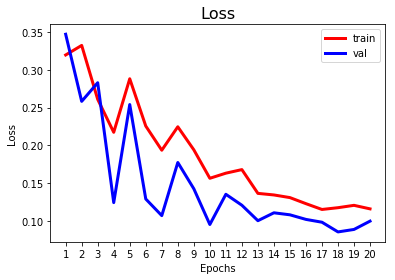

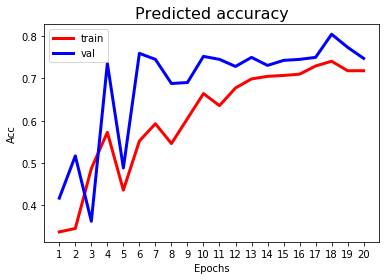

In [57]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 绘制第一个图，在一幅图上画两条曲线
plt.figure()
plt.title("Loss",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(1, 21, 1.0))
plt.plot(range(1,epochs + 1), loss_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), loss_val,color='b', linewidth = 3.0, label='val')
plt.legend()  # 设置图例和其中的文本的显示

# 绘制第二个图，在一幅图上画两条曲线
plt.figure()
plt.title("Predicted accuracy",fontsize=16)
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.xticks(np.arange(1, 21, 1.0))
plt.plot(range(1,epochs + 1), acc_train,color='r', linewidth = 3.0, label='train')
plt.plot(range(1,epochs + 1), acc_val,color='b', linewidth = 3.0, label='val')
plt.legend()  # 设置图例和其中的文本的显示

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])
GroundTruth:     81    81    79    79
Predicted:     81    81    79    79


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


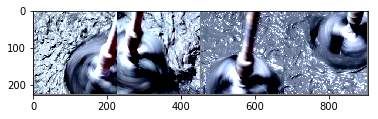

In [29]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('75', '77', '79', '81')

dataiter = iter(dataloders['val'])
images, labels = dataiter.next()
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[z]] for z in range(4)))

# test
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[z]] for z in range(4)))